# Hybrid (CSV) Model

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
import logging
import json
from dotenv import load_dotenv

### Parameters

In [2]:
load_dotenv()

# Simulation
TUBE_X = 0.21e-3 # 0.21 mm
TUBE_Y = 0.21e-3 # 0.21 mm
U_MAX = 30.0e-3 # 30.0 mm/s
ROTATION_Y = 105 # deg
TUBE_CENTER = torch.tensor([0.0, 0.2e-3, 25e-3], dtype=torch.float32) # [0, 0.2*mm, 25*mm]

# Run
TRAIN_DATA = os.getenv("TRAIN_DATA_PATH")
INF_DATA = os.getenv("INF_DATA_PATH")
INITIAL_LR = 0.0005
EPOCHS = 50000
SCHEDULER_STEP = 5000
SCHEDULER_GAMMA = 0.75

# Loss Weights
LOSS_WEIGHT_IC = 10000.0
LOSS_WEIGHT_PHYSICS = 1.0
LOSS_WEIGHT_DATA = 10.0

# Performance
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEVICE, TRAIN_DATA, INF_DATA, sep="\n")

cuda:0
/teamspace/studios/this_studio/Bubble-PINN/Data/gtl_b1000_t500.csv
/teamspace/studios/this_studio/Bubble-PINN/Data/gtl_b100_t500.csv


### Logging

In [3]:
# Clear existing handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Create folder to store log for this run
run_date = datetime.now().strftime("%m-%d-%Y")
run_time = datetime.now().strftime("%H_%M_%S")

output_dir = f"output/{run_date}/{run_time}"

os.makedirs(output_dir, exist_ok=True)

# Initialize Logger
log_path = os.path.join(output_dir, "log.json")
logging.basicConfig(
    filename=log_path,
    level=logging.INFO,
    format=""
)
logger = logging.getLogger()

# Log Parameters
log = {
    "HYBRID MODEL": {
        "PARAMETERS": {
            "Simulation": {
                "TUBE_X": TUBE_X,
                "TUBE_Y": TUBE_Y,
                "U_MAX": U_MAX,
                "ROTATION_Y": ROTATION_Y,
                "TUBE_CENTER": [0.0, 0.2e-3, 25e-3]
            },
            "Run": {
                "TRAIN DATA": TRAIN_DATA,
                "INFERENCE DATA": INF_DATA,
                "INITIAL_LR": INITIAL_LR,
                "EPOCHS": EPOCHS
            },
            "Loss Weights": {
                "LOSS_WEIGHT_IC": LOSS_WEIGHT_IC,
                "LOSS_WEIGHT_PHYSICS": LOSS_WEIGHT_PHYSICS,
                "LOSS_WEIGHT_DATA": LOSS_WEIGHT_DATA,
                "SCHEDULER STEP": SCHEDULER_STEP,
                "SCHEDULER GAMMA": SCHEDULER_GAMMA
            },
            "Performance": {
                "DEVICE": str(DEVICE)
            }
        },
        "TRAIN DATASET": {},
        "INFERENCE DATASET": {},
        "TRAIN LOSS": [],
        "INFERENCE LOSS": {}
    }
}

### Training Dataset

In [4]:
class BubbleDataset(Dataset):
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        self.df = self.df.sort_values(["id", "t"])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, row, col):
        return self.df.iat[row, col]
    
    def get_initial_positions(self):
        # Get the initial positions of each and every bubble
        grouped = self.df.groupby("id")
        initial_positions = grouped.first()[["x", "y", "z"]].values
        initial_positions = torch.tensor(initial_positions, dtype=torch.float32)

        return initial_positions
    
    def get_time_vector(self):
        # Get a time vector of the times (unique) in the dataset
        times = self.df["t"].unique()
        times = torch.tensor(times, dtype=torch.float32).reshape(-1, 1)

        return times
        
    def get_times(self):
        # Extract time column from dataset
        return torch.tensor(self.df["t"].values, dtype=torch.float32)

    def get_ids(self):
        # Extract id column from dataset
        return torch.tensor(self.df["id"].values, dtype=torch.long)
    
    def get_all_positions(self):
        # Extract x, y, z columns from dataset
        return torch.tensor(self.df[["x", "y", "z"]].values, dtype=torch.float32)
    
    def get_velocities(self):
        # Extract vx, vy, vz columns from dataset
        return torch.tensor(self.df[["vx", "vy", "vz"]].values, dtype=torch.float32)

In [5]:
# Setup training dataset
train_dataset = BubbleDataset(TRAIN_DATA)

# Get core tensors
train_times = train_dataset.get_times().reshape(-1, 1).to(DEVICE)
train_targets = train_dataset.get_all_positions().to(DEVICE)
train_ids = train_dataset.get_ids()
train_initial_positions = train_dataset.get_initial_positions().to(DEVICE)

# Use IDs to index the corresponding initial position for each sample
train_init_pos = train_initial_positions[train_ids].to(DEVICE)

# Build input: [t, x0, y0, z0]
train_inputs = torch.cat([train_times, train_init_pos], dim=1).to(DEVICE)

In [6]:
# Log dataset shapes
log["HYBRID MODEL"]["TRAIN DATASET"] = {
    "Bubbles": len(train_ids.unique()),
    "Frames": len(train_times.unique())
}

### Model

In [7]:
# Get scaling parameters
train_times_full = train_dataset.get_times().to(DEVICE) # Get time column
t_min, t_max = train_times_full.min(), train_times_full.max() # Extract min and max
pos_min, indices = train_initial_positions.min(dim=0) # Min across bubbles for each dim (x,y,z). Don't need indices
pos_max, indices = train_initial_positions.max(dim=0) # Max across bubbles for each dim (x,y,z). Don't need indices
eps = 1e-8 # Prevent division by zero if min == max

SCALING_PARAMS = {
    't_min': t_min, 
    't_max': t_max,
    'pos_min': pos_min, 
    'pos_max': pos_max, 
    'eps': eps
    }

class BubbleModel(nn.Module):
    def __init__(self, scaling_params=SCALING_PARAMS): 
        super().__init__()
        self.scaling_params = scaling_params
        self.net = nn.Sequential(
            nn.Linear(4, 128), # t (normalized), x0 (normalized), y0 (normalized), z0 (normalized)
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128 , 3) # x(t), y(t), z(t)
        )

    def normalize_inputs(self, t, init_pos):
        scaling_params = self.scaling_params

        t_min = scaling_params['t_min'].to(DEVICE)
        t_max = scaling_params['t_max'].to(DEVICE)
        pos_min = scaling_params['pos_min'].to(DEVICE)
        pos_max = scaling_params['pos_max'].to(DEVICE)
        eps = scaling_params['eps']

        # Normalize t to [-1, 1]
        t_norm = 2 * (t - t_min) / (t_max - t_min + eps) - 1

        # Normalize init_pos to [-1, 1] per dimension
        pos_norm = 2 * (init_pos - pos_min) / (pos_max - pos_min + eps) - 1

        return torch.cat([t_norm, pos_norm], dim=1)

    def forward(self, t, init_pos):
        norm_input = self.normalize_inputs(t, init_pos)
        return self.net(norm_input)

In [8]:
model = BubbleModel().to(DEVICE)

### Poiseuille Velocity
* Source: https://github.com/marcelolerendegui/buff/blob/main/examples/cross_tube/velocity_in_tube.m

In [9]:
def poiseuille_velocity(pos, tube_center=TUBE_CENTER, tube_x=TUBE_X, tube_y=TUBE_Y, U_max=U_MAX, rotation=ROTATION_Y):
    device = pos.device

    pos = pos.to(device)
    tube_center = tube_center.to(device)

    theta = math.radians(rotation)

    # Setup tube direction vector and local axes
    e3 = torch.tensor([math.sin(theta), 0.0, math.cos(theta)], dtype=torch.float32, device=device) # tube direction
    Y = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device)
    e1 = torch.cross(Y, e3)
    e2 = torch.cross(e3, e1)

    # Compute formula
    relative_pos = pos - tube_center
    pos_local_e1 = (relative_pos * e1).sum(dim=1)
    pos_local_e2 = (relative_pos * e2).sum(dim=1)

    rad1 = tube_x / 2.0
    rad2 = tube_y / 2.0
    a = pos_local_e1 / rad1 
    b = pos_local_e2 / rad2 

    magnitude = U_max * (1.0 - a * b)
    velocity = magnitude.unsqueeze(1) * e3

    return velocity

### Physics Loss

In [10]:
def physics_loss(model, t, init_pos, rotation=ROTATION_Y):
    t.requires_grad_(True)
    pred_pos = model(t, init_pos) # Predict positions

    # Compute individual component velocities based on prediction
    grads = []
    for i in range(3):
        grad_i = torch.autograd.grad(
            outputs=pred_pos[:, i], # Differentiate position
            inputs=t, # W.r.t time
            grad_outputs=torch.ones_like(pred_pos[:, i]),
            create_graph =True,
            retain_graph=True
        )[0]
        grads.append(grad_i)
    
    velocity_pred = torch.cat(grads, dim=1)

    # Compute true physics-based velocity using predicted position
    velocity_true = poiseuille_velocity(pred_pos, rotation=rotation)

    # Calculate MSE between the full predicted and true velocity vectors
    loss = nn.MSELoss()(velocity_pred, velocity_true)

    return loss

### Training

In [11]:
optimizer = Adam(model.parameters(), lr=INITIAL_LR)
scheduler = lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA) # Adjust params

# Checkpoint setup
best_loss = float('inf')
best_model_path = None

print("Training Started")
for epoch in tqdm(range(EPOCHS)):
    model.train()
    optimizer.zero_grad()

    # Prepare tensors for loss calculations
    t_all = train_inputs[:, :1] # Time column for all rows
    init_pos_all = train_inputs[:, 1:] # Initial pos corresponding to each row
    t_all_grad = t_all.clone().detach().requires_grad_(True) # Time with gradient enabled

    # Prediction for all time steps (needed for Data and Physics loss)
    pred_pos = model(t_all_grad, init_pos_all)

    # Calculate losses (data & phys)
    data_loss = MSELoss()(pred_pos, train_targets)
    phys_loss = physics_loss(model, t_all_grad, init_pos_all)

    # Calculate initial condition (IC) loss
    t_initial = torch.zeros((len(train_initial_positions), 1), device=DEVICE, requires_grad=False)
    pred_pos_initial = model(t_initial, train_initial_positions)
    initial_cond_loss = MSELoss()(pred_pos_initial, train_initial_positions)

    # Calculate total loss (weighted)
    loss = (LOSS_WEIGHT_DATA * data_loss +
            LOSS_WEIGHT_PHYSICS * phys_loss +
            LOSS_WEIGHT_IC * initial_cond_loss)

    # Backpropagation, gradient clipping, optimization, LR scheduling
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    # Checkpoint best model
    current_loss = loss.item()

    if current_loss < best_loss:
        old_best_path = best_model_path
        best_loss = current_loss

        loss_str = f"{current_loss:.6f}".replace('.', 'p')
        new_best_filename = f"hybrid_model_epoch_{epoch}_loss_{loss_str}.pt"

        best_model_path = os.path.join(output_dir, new_best_filename)

        torch.save(model.state_dict(), best_model_path)

        # Clean up previous best model file
        if old_best_path is not None and os.path.exists(old_best_path):
            os.remove(old_best_path)

    # Logging
    if epoch % SCHEDULER_STEP == 0 or epoch == EPOCHS - 1:
        dl = data_loss.item()
        pl = phys_loss.item()
        il = initial_cond_loss.item()
        tl = current_loss

        print(f"Epoch {epoch}: Total Loss = {tl:.6f} | Data = {dl:.6f} | Physics = {pl:.6f} | IC = {il:.6f}")

        log["HYBRID MODEL"]["TRAIN LOSS"].append({
            "Epoch": epoch, "Physics Loss": pl, "Data Loss": dl, "IC Loss": il, "Total Loss": tl
        })

print(f"\nTraining complete. Best model saved to {best_model_path} with loss {best_loss:.6f}")

Training Started


  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_138583/2417967609.py:12: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  e1 = torch.cross(Y, e3)


Epoch 0: Total Loss = 1362291968.000000 | Data = 0.030356 | Physics = 1362291840.000000 | IC = 0.012224
Epoch 5000: Total Loss = 245.201706 | Data = 0.005742 | Physics = 244.950394 | IC = 0.000019
Epoch 10000: Total Loss = 0.484126 | Data = 0.001034 | Physics = 0.416303 | IC = 0.000006
Epoch 15000: Total Loss = 0.387299 | Data = 0.000390 | Physics = 0.374665 | IC = 0.000001
Epoch 20000: Total Loss = 0.034341 | Data = 0.000325 | Physics = 0.004574 | IC = 0.000003
Epoch 25000: Total Loss = 0.004048 | Data = 0.000335 | Physics = 0.000198 | IC = 0.000000
Epoch 30000: Total Loss = 0.004990 | Data = 0.000321 | Physics = 0.001507 | IC = 0.000000
Epoch 35000: Total Loss = 0.003095 | Data = 0.000296 | Physics = 0.000069 | IC = 0.000000
Epoch 40000: Total Loss = 0.003119 | Data = 0.000258 | Physics = 0.000105 | IC = 0.000000
Epoch 45000: Total Loss = 0.002378 | Data = 0.000218 | Physics = 0.000012 | IC = 0.000000
Epoch 49999: Total Loss = 0.002311 | Data = 0.000202 | Physics = 0.000183 | IC = 0.

### Plot Loss Curve

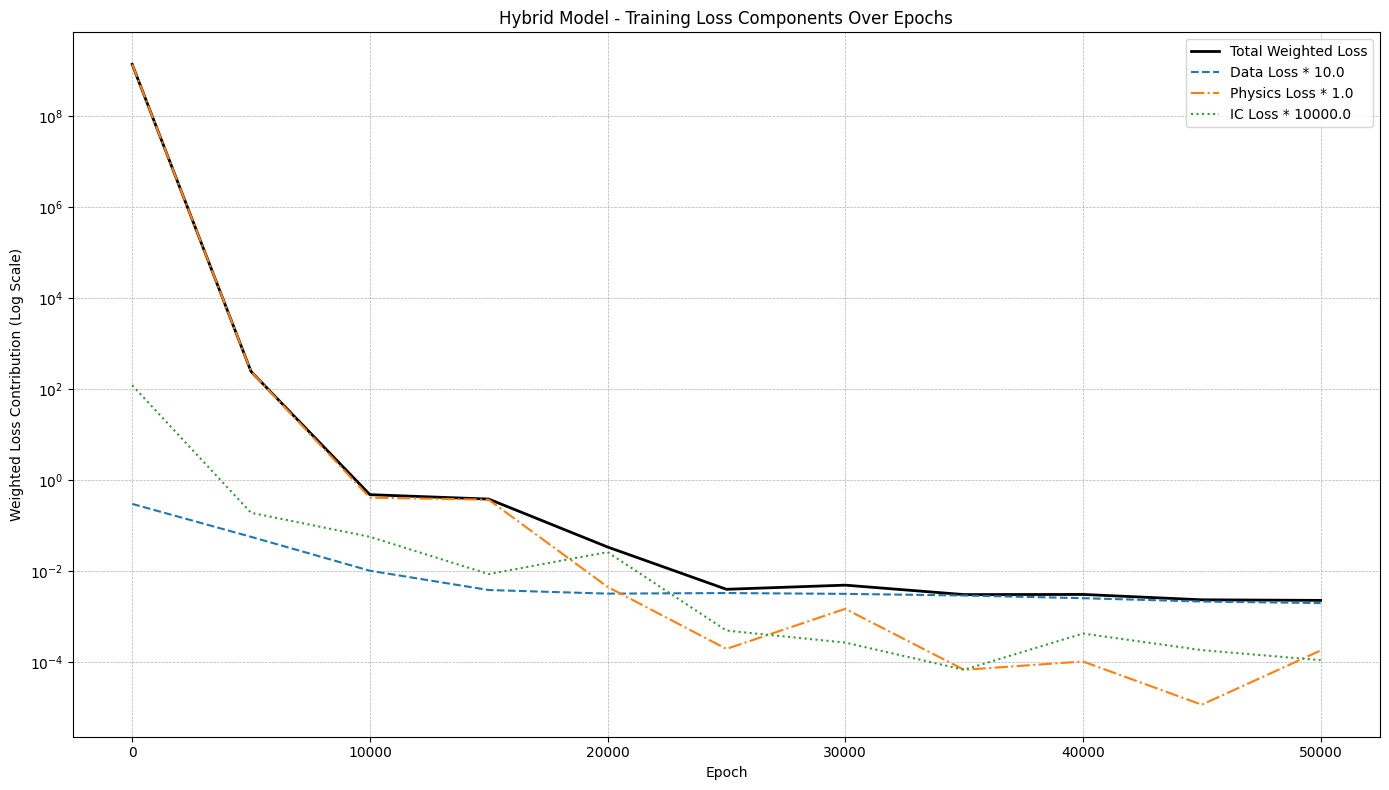

In [12]:
loss_data_list = log["HYBRID MODEL"]["TRAIN LOSS"]

epochs = []
total_losses = []
physics_losses = []
data_losses = []
ic_losses = []

for entry in loss_data_list:
    epochs.append(entry["Epoch"])
    total_losses.append(entry.get("Total Loss", float('nan')))
    physics_losses.append(entry.get("Physics Loss", float('nan')))
    data_losses.append(entry.get("Data Loss", float('nan')))
    ic_losses.append(entry.get("IC Loss", float('nan')))

# Plot loss curve
plt.figure(figsize=(14, 8))

# Plot total loss
plt.plot(epochs, total_losses, label='Total Weighted Loss', linewidth=2, color='black')

# Plot individual weighted loss components
weighted_data = [dl * LOSS_WEIGHT_DATA for dl in data_losses]
weighted_physics = [pl * LOSS_WEIGHT_PHYSICS for pl in physics_losses]
weighted_ic = [il * LOSS_WEIGHT_IC for il in ic_losses]

plt.plot(epochs, weighted_data, label=f'Data Loss * {LOSS_WEIGHT_DATA}', linestyle='--')
plt.plot(epochs, weighted_physics, label=f'Physics Loss * {LOSS_WEIGHT_PHYSICS}', linestyle='-.')
plt.plot(epochs, weighted_ic, label=f'IC Loss * {LOSS_WEIGHT_IC}', linestyle=':')


# Formatting
plt.yscale('log')
plt.title('Hybrid Model - Training Loss Components Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Weighted Loss Contribution (Log Scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show & Save
plt.savefig(os.path.join(output_dir, "hybrid_loss_curve.png"))
plt.show()
plt.close() 

### Inference Dataset

In [13]:
# Setup inference dataset
inf_dataset = BubbleDataset(INF_DATA)

# Get core tensors
inf_times = inf_dataset.get_times().reshape(-1, 1).to(DEVICE)
inf_targets = inf_dataset.get_all_positions().to(DEVICE)
inf_ids = inf_dataset.get_ids().to(DEVICE)
inf_initial_positions = inf_dataset.get_initial_positions().to(DEVICE)

# Use IDs to index the corresponding initial position for each sample
inf_init_pos = inf_initial_positions[inf_ids].to(DEVICE)

# Build input: [t, x0, y0, z0]
inf_inputs = torch.cat([inf_times, inf_init_pos], dim=1).to(DEVICE)

In [14]:
# Log dataset shapes
log["HYBRID MODEL"]["INFERENCE DATASET"] = {
    "Bubbles": len(inf_ids.unique()),
    "Frames": len(inf_times.unique())
}

### Inference

In [15]:
# Initialize model architecture
inference_model = BubbleModel().to(DEVICE)
inference_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
inference_model.eval()

# Get standard inputs and gradient inputs
t_inf = inf_inputs[:, :1]
init_pos_inf = inf_inputs[:, 1:]
t_inf_grad = t_inf.clone().detach().requires_grad_(True) # For velocity/physics loss calc

# Get position predictions 
with torch.no_grad():
    pred_pos = inference_model(t_inf, init_pos_inf)

# Get predictions again WITH grad graph for velocity calculation
pred_pos_for_grad = inference_model(t_inf_grad, init_pos_inf)

# Calculate predicted velocity
grads = []
for i in range(3):
    grad_i = torch.autograd.grad(
        outputs=pred_pos_for_grad[:, i], # Differentiate position
        inputs=t_inf_grad, # W.r.t time
        grad_outputs=torch.ones_like(pred_pos_for_grad[:, i]),
        create_graph=False,
        retain_graph=True
    )[0]
    grads.append(grad_i)
    
velocity_pred = torch.cat(grads, dim=1)

# Calculate losses (data and phys)
data_loss_inf = MSELoss()(pred_pos, inf_targets).item()
phys_loss_inf = physics_loss(inference_model, t_inf_grad, init_pos_inf).item()

# Calculate velocity losses
with torch.no_grad():
    # Load ground truth velocities
    true_vel = inf_dataset.get_velocities().to(DEVICE)

    # Calculate full velocity loss
    full_velocity_loss_val = MSELoss()(velocity_pred, true_vel).item()

    # Projected velocities
    theta = math.radians(ROTATION_Y);
    e3 = torch.tensor([math.sin(theta), 0.0, math.cos(theta)], device=DEVICE)
    vel_proj_pred = (velocity_pred * e3).sum(dim=1, keepdim=True)
    vel_proj_true = (true_vel * e3).sum(dim=1, keepdim=True)

    # Calculate projected velocity loss
    projected_velocity_loss_val = MSELoss()(vel_proj_pred, vel_proj_true).item()

# Print losses
print(f"""Inference Results:
Data Loss = {data_loss_inf:.6f}
Physics Loss = {phys_loss_inf:.6f}
Projected Velocity Loss = {projected_velocity_loss_val:.6f}
Full Velocity Loss = {full_velocity_loss_val:.6f}
""")

# Log losses
log["HYBRID MODEL"]["INFERENCE LOSS"] = {
    "Best Model Path": best_model_path,
    "Data Loss": data_loss_inf,
    "Physics Loss": phys_loss_inf,
    "Projected Velocity Loss": projected_velocity_loss_val,
    "Full Velocity Loss": full_velocity_loss_val
}

# Store outputs for plotting
torch.save({
    "inputs": inf_inputs.cpu(),
    "targets": inf_targets.cpu(),
    "preds": pred_pos.cpu(),
    "ids": inf_ids.cpu(),
    "vel_pred": velocity_pred.detach().cpu(), 
    "vel_proj_pred": vel_proj_pred.detach().cpu(),
    "vel_proj_true": vel_proj_true.detach().cpu()
}, os.path.join(output_dir, "inference_outputs.pt"))

print(f"Inference outputs saved to {output_dir}/inference_outputs.pt")

Inference Results:
Data Loss = 0.000196
Physics Loss = 0.000071
Projected Velocity Loss = 0.000652
Full Velocity Loss = 0.000217

Inference outputs saved to output/04-20-2025/19_43_12/inference_outputs.pt


/tmp/ipykernel_138583/2344959413.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))


### Log Data

In [16]:
# Log run data to file
logger.info(json.dumps(log, indent=2))

# Clear logging handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

### Plot Data

/tmp/ipykernel_138583/3190612140.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(output_filepath)


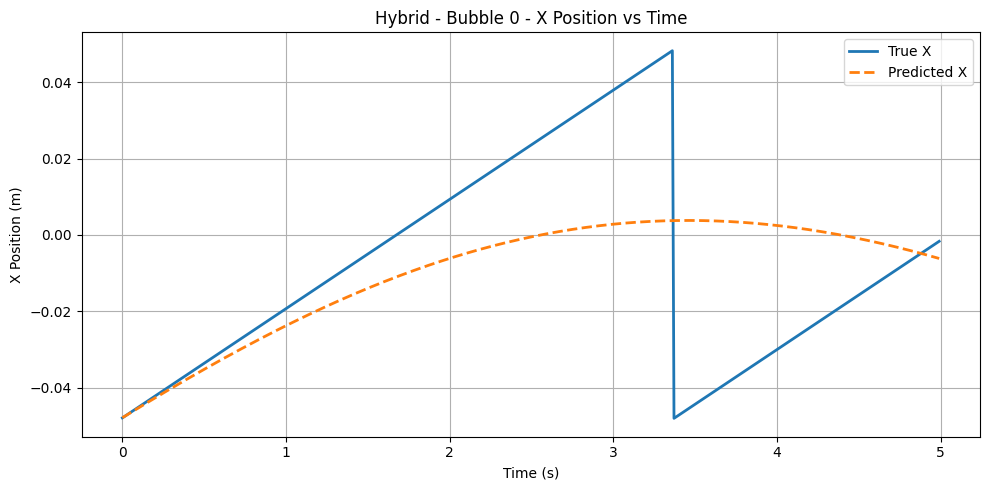

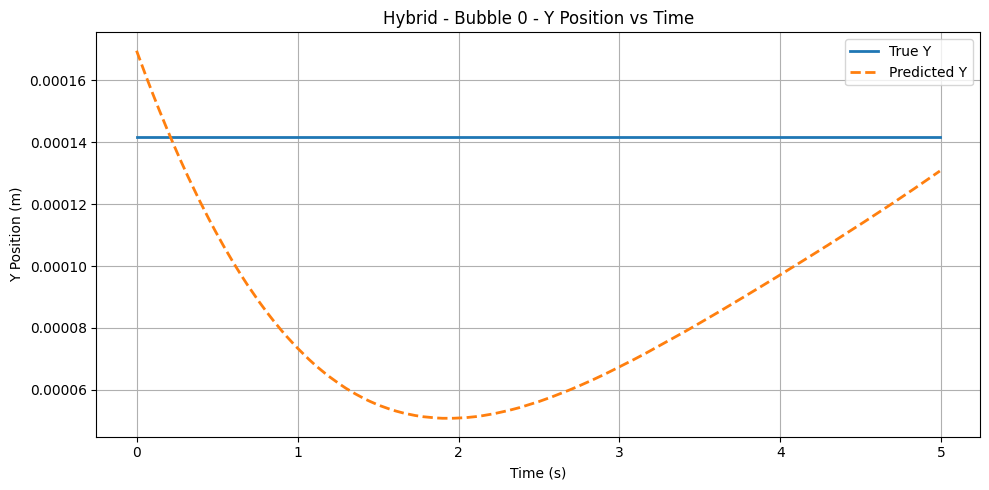

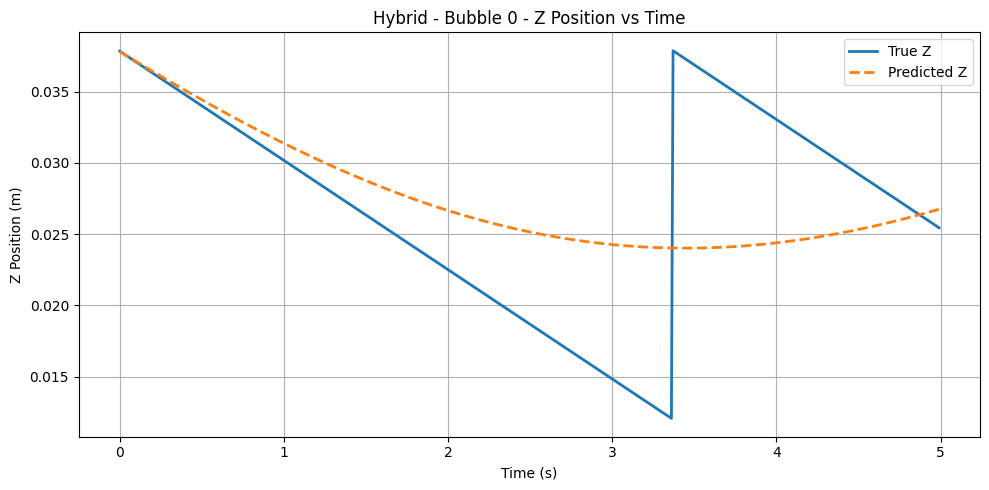

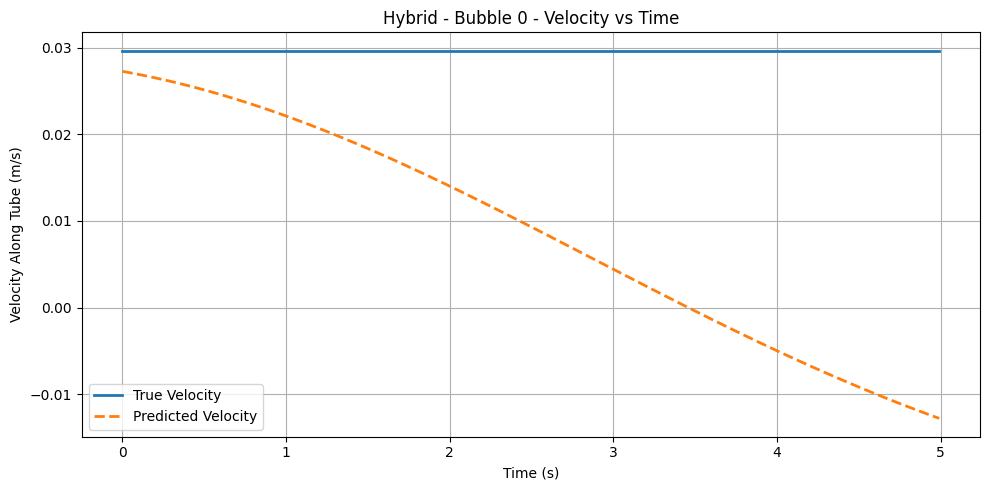

Plots saved to output/04-20-2025/19_43_12


In [ ]:
# Load inference outputs
output_filepath = os.path.join(output_dir, "inference_outputs.pt")

data = torch.load(output_filepath)
inputs = data["inputs"]
targets = data["targets"]
preds_continuous = data["preds"]
bubble_ids = data["ids"]
vel_proj_pred = data["vel_proj_pred"]

# Convert predictions to numpy
preds_np = preds_continuous.cpu().numpy() 

# Recalculate ground truth velocity for plotting
true_vel_plot = inf_dataset.get_velocities() # Get full true velocities [N, 3] CPU tensor

# Calculate e3 vector
theta_plot = math.radians(ROTATION_Y);
e3_plot = torch.tensor([math.sin(theta_plot), 0.0, math.cos(theta_plot)], dtype=torch.float32) 

# Project true velocity
vel_proj_true_plot = (true_vel_plot * e3_plot).sum(dim=1, keepdim=True)

# Plot
bubble_id = 0
axes = ['X', 'Y', 'Z'] 

mask = bubble_ids == bubble_id
times_np = inputs[mask][:, 0].cpu().numpy() # Get corresponding times as numpy

# Position (X, Y, Z)
for component_idx, component_name in enumerate(axes):
    true_component = targets[mask][:, component_idx].cpu().numpy()
    pred_component = preds_np[mask][:, component_idx] # Raw prediction from numpy array

    plt.figure(figsize=(10, 5))
    plt.plot(times_np, true_component, label=f"True {component_name}", linewidth=2)
    plt.plot(times_np, pred_component, label=f"Predicted {component_name}", linestyle="--", linewidth=2)
    plt.title(f"Hybrid - Bubble {bubble_id} - {component_name} Position vs Time")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{component_name} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_filename = f"bubble_{bubble_id}_{component_name}_vs_t_Hybrid.png"
    plt.savefig(os.path.join(output_dir, plot_filename))
    plt.show()

# Projected Velocity
v_true_np = vel_proj_true_plot[mask].squeeze().cpu().numpy() 
v_pred_np = vel_proj_pred[mask].squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(times_np, v_true_np, label="True Velocity", linewidth=2)
plt.plot(times_np, v_pred_np, label="Predicted Velocity", linestyle="--", linewidth=2)
plt.title(f"Hybrid - Bubble {bubble_id} - Velocity vs Time")
plt.xlabel("Time (s)") # Added units
plt.ylabel("Velocity Along Tube (m/s)") # Added units
plt.legend()
plt.grid(True)
plt.tight_layout()
plot_filename = f"bubble_{bubble_id}_v_vs_t_Hybrid.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

print(f"Plots saved to {output_dir}")